In [ ]:
#Dependencies cell
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.stats import mannwhitneyu
from matplotlib import pyplot as plt
from matplotlib import colors as colors
import matplotlib.image as mpimg
import seaborn as sns

if 'Supplementary Dataset 10N.xlsx' not in os.listdir():
    %cd ./data
    print('Local mount at SUPPNAFLD/data')
else:
    print(os.listdir())

c:\Users\sjobl\OneDrive\Desktop\SUPPNAFLD\data
Local mount at SUPPNAFLD/data


# Functions
``RF_Execute``: runs Random Forest and create a confusion matrix \\
``save_RF``: saves the result from RF_Execute to a google speadsheet \\
##RF_Execute input: 
``data``: data for all patients \\
``meta_data``: information of which liver fat class each patient has \\
``tester_data``: if seperate test data is desired \\
``tester_meta``: liver fat class data for seperate test data \\
``name``: name of the combinations of biomarkers, neccecary if a confusion matrix is desired \\
``max_iter``: maximum number of trees in the forest \\


In [ ]:
def RF_Execute(data, meta_data, tester_data=None, tester_meta=None, name=None, max_iter = 100):
  randomstate = 123
  data_copy = data.copy()

  #sort data and fills any N/a
  filled_data = pd.DataFrame()
  for i in meta_data.unique():
    temp_data = (data_copy.reindex(meta_data[meta_data==i].index))
    filled_data = pd.concat([filled_data,temp_data.fillna(temp_data.mean())])
  filled_data = filled_data.fillna(0)
  liver_fat=meta_data.reindex(filled_data.index)

  #split training data into, training and testing parts
  train_data, test_data, train_liver_fat, test_liver_fat = train_test_split(filled_data, liver_fat, test_size=0.3,random_state=randomstate)
  
  #checks if extra test data is specified and if not use from a subset of training data
  if tester_data is None:
    tester_data = test_data
    tester_liver_fat = test_liver_fat
  else:
    #sort and fills any N/a in tester data
    tester_copy = tester_data.copy()
    filled_tester = pd.DataFrame()
    for i in tester_meta.unique():
      temp_tester = tester_copy.reindex(tester_meta[tester_meta==i].index)
      filled_tester = pd.concat([filled_tester,temp_tester.fillna(temp_tester.mean())])
    tester_data = filled_tester.fillna(0)
    tester_liver_fat = tester_meta.reindex(tester_data.index)

  #defining an internal fuction to execute Random Forest
  def RF(num_trees):
    forest = RandomForestClassifier(n_estimators = num_trees,bootstrap = True, oob_score = True, random_state = randomstate)
    forest.fit(train_data,train_liver_fat)
    pred_liver_fat = forest.predict(test_data)
    return [num_trees, metrics.accuracy_score(test_liver_fat, pred_liver_fat),forest.oob_score_]
  
  #tests Random Forest with different sizes and optimizes
  forests = list(map(RF, range(10, max_iter)))
  forests = pd.DataFrame(forests, columns=['var', 'accuracy', 'oob']).set_index('var')
  selected_forest_size = forests.sort_values(['accuracy','oob']).drop_duplicates().index[-1]
  
  #sort markers according to importance in forest
  forest= RandomForestClassifier(n_estimators = selected_forest_size,bootstrap = True, oob_score = True, random_state = randomstate)
  forest.fit(train_data, train_liver_fat)
  pred_liver_fat = forest.predict(tester_data)
  feature_imp = pd.Series(forest.feature_importances_, index=filled_data.columns, name = 'Importance').sort_values(ascending=False)
  feature_imp = feature_imp[feature_imp>0]
  accuracy = metrics.accuracy_score(tester_liver_fat, pred_liver_fat)
  oob_score = forest.oob_score_
  print("Accuracy %d: %f | OOB Score: %f" % (selected_forest_size, accuracy, oob_score))

  #creates and saves a confusion matrix
  if name is not None:
    conf_matrix = metrics.confusion_matrix(tester_liver_fat.to_list(), pred_liver_fat, labels=['None', 'Mild', 'Moderate', 'Severe'])
    colormap = colors.LinearSegmentedColormap.from_list("", ["#dedad2","#badbdb", "#98d1d1", "#76c8c8",  "#54bebe", '#348fa7', '#37659e', '#413d7b'])
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['None', 'Mild', 'Moderate', 'Severe'])
    disp.plot(cmap=colormap)
    plt.title(str(name))
    plt.savefig(f'../graphs/{name}_cm.png', bbox_inches='tight')

  return feature_imp, accuracy, oob_score

##save_RF input:
`datasheet`: a series where index is name of biomarkers and values the importance score \\
`accuracy`: a float with accuracy \\
`oob`: a float with oob-score \\
`sheetname`: name of the sheet where `datasheet` is to be saved \\
\
Will replace sheets if they already exists

In [ ]:
def save_RF(datasheet, accuracy, oob, sheetname):
  size = datasheet.size
  #Creates correct dataframe
  RF_list = [[index, value] for index,value in zip(datasheet.index.tolist(), datasheet.tolist())]
  data = pd.DataFrame(RF_list, columns=['Biomarker', 'Significance']).set_index('Biomarker')
  data[''] = [f'Accuracy: {accuracy}', f'oob: {oob}'] + list(np.full(size-2, None))

  #check if the file or sheet already exist, otherwise creates it
  try:
    RF_file = pd.read_excel('../results/RF.xlsx')
    try:
      RF_file = pd.read_excel('../results/RF.xlsx', sheet_name=sheetname)
    except:
      pass
    finally:
      with pd.ExcelWriter('../results/RF.xlsx', mode="a", engine="openpyxl", if_sheet_exists='replace') as writer:
        data.to_excel(writer, sheet_name=sheetname)
  except:
    data.to_excel('../results/RF.xlsx', sheet_name=sheetname)
    #creates a new sheet and defines the column names


#Read data
Reads all omics data from Excel and save them as dataframes.

In [ ]:
#reads clinical data
clinical = pd.read_excel("Supplementary Dataset 1N.xlsx", 'Dataset 1A', index_col=0).dropna(how='all',axis=1)
clinical_values = clinical.iloc[0:, 5:]
metadata_clinical = clinical['Liver Fat Class']

In [ ]:
#read clinical data first

#reads metabolomics data
available = pd.read_excel("Supplementary Dataset 7N.xlsx", 'Sample Availability', index_col=0)
metabolomics = pd.read_excel("Supplementary Dataset 7N.xlsx", 'Raw Metabolomics Data', index_col=0)
  #check which patients have data
available = available[available == 'YES'].dropna()

  #saves extra info about the metabolites
metabolomics_map = metabolomics.iloc[0:, 0:10]
  #separate out paitients with data and the values of the markers
metabolomic_values = metabolomics.iloc[0:, 10:]
metadata_metabolomics = metadata_clinical.reindex(index = available.index)
metabolomic_values = metabolomic_values[available.index]
  #removes metabolites with more than 50% NA, fills empty spaces with NaN and convert to float
metabolomic_values = metabolomic_values[(metabolomic_values.isna().sum(1)/metabolomic_values.shape[1]) < 0.5].T

In [ ]:
#read clinical data first

#reads proteomics data
available = pd.read_excel("Supplementary Dataset 10N.xlsx", 'Sample Availability', index_col=0)
proteomics = pd.read_excel("Supplementary Dataset 10N.xlsx", 'NPX Values', index_col=0)

  #check which patients have data
available = available[available == 'YES'].dropna()
metadata_proteomics = metadata_clinical.reindex(available.index)
proteomic_values = proteomics[available.index]

#removes proteins with more than 50% NA, fills empty spaces with NaN and convert to float
proteomic_values = proteomic_values[(proteomic_values.isna().sum(1)/proteomic_values.shape[1]) < 0.5].T

In [ ]:
#read clinical data first

#reads metagenomic gut data
gut_biome = pd.read_excel("Supplementary Dataset 3N.xlsx", 'Abundance_Gut', index_col=0)
  #sort out to only check species
gut_biome = gut_biome[gut_biome.index.str.contains('\|s__')].dropna(how = 'all').T
gut_biome.columns = [i.split('|')[-1][3:] for i in gut_biome.columns]
metadata_gut = metadata_clinical.reindex(gut_biome.index)

# reads metagenomic oral data
oral_biome = pd.read_excel("Supplementary Dataset 3N.xlsx", 'Abundance_Oral', index_col=0)
  #sort out to only check species
oral_biome = oral_biome[oral_biome.index.str.contains('\|s__')].dropna(how = 'all').T
oral_biome.columns = [i.split('|')[-1][3:] for i in oral_biome.columns]
metadata_oral = metadata_clinical.reindex(oral_biome.index)

In [ ]:
#reads revisit data
#clinical
clinical2 = pd.read_excel("Supplementary Dataset 2N.xlsx", 'Dataset 2A', index_col=0)
clinical_values2 = clinical2.dropna(how='all',axis=1).iloc[:, 1:]
metadata2 = clinical2['Class']

#metabolomic
metabolomics2 = pd.read_excel("Supplementary Dataset 2N.xlsx", 'Dataset 2G-Metabolomics', index_col=0)
metabolomic_values2 = metabolomics2.dropna(how='all',axis=1).replace(r'^\s*$', np.nan, regex=True)

#proteomics
proteomics2 = pd.read_excel("Supplementary Dataset 2N.xlsx", 'Dataset 2H-Proteomics', index_col=0)
proteomic_values2 = proteomics2.dropna(how='all',axis=1).replace(r'^\s*$', np.nan, regex=True)

#gut
gut2 = pd.read_excel("Supplementary Dataset 2N.xlsx", 'Dataset 2F-Gut', index_col=0)
gut_values2 = gut2.dropna(how='all',axis=1).replace(r'^\s*$', np.nan, regex=True)

#oral
oral2 = pd.read_excel("Supplementary Dataset 2N.xlsx", 'Dataset 2E-Oral', index_col=0)
oral_values2 = oral2.dropna(how='all',axis=1).replace(r'^\s*$', np.nan, regex=True)

redata = pd.concat([clinical_values2, metabolomic_values2, proteomic_values2, gut_values2, oral_values2], axis=1)

#Mann Whitney U test
For clinical, metabolomic and proteomic data

In [ ]:
#read clinical data first

#divides the data by liver fat class
zero = clinical_values.reindex(index= metadata_clinical[metadata_clinical == 'None'].index)
low = clinical_values.reindex(index= metadata_clinical[metadata_clinical == 'Mild'].index)
moderate = clinical_values.reindex(index= metadata_clinical[metadata_clinical == 'Moderate'].index)
strong = clinical_values.reindex(index= metadata_clinical[metadata_clinical == 'Severe'].index)

#runs the mann whitney U test for clinical data
mann_whitney_u_result = []

for i in clinical_values.columns:
    result_low = mannwhitneyu(low[i].dropna(),zero[i].dropna())[1]
    result_moderate = mannwhitneyu(moderate[i].dropna(),zero[i].dropna())[1]
    result_strong = mannwhitneyu(strong[i].dropna(),zero[i].dropna())[1]
    mann_whitney_u_result.append([i, result_low, result_moderate, result_strong])

#write to spreadsheet Mann U
mann_whitney_u_result = pd.DataFrame(mann_whitney_u_result,columns=['Measurements', 'None vs Mild', 'None vs Medium', 'None vs Severe']).set_index('Measurements')

try:
    with pd.ExcelWriter('../results/Mann U.xlsx', mode="a", engine="openpyxl", if_sheet_exists='replace') as writer:
        mann_whitney_u_result.to_excel(writer, sheet_name='Clinical')
except:
    mann_whitney_u_result.to_excel('../results/Mann U.xlsx', sheet_name='Clinical')

In [ ]:
#creates and saves heatmap of p-values for clinical markers
clin_mwu = pd.DataFrame(mann_whitney_u_result, columns=['Clinical value', 'None vs Low', 'None vs Medium', 'None vs Severe'])
clin_mwu = clin_mwu.set_index(clin_mwu['Clinical value']).iloc[1:]
cmap = colors.LinearSegmentedColormap.from_list("", ["#dedad2","#badbdb", "#98d1d1", "#76c8c8",  "#54bebe", '#348fa7', '#37659e', '#413d7b'])
plt.figure(figsize=(5, 10))
sns.heatmap(clin_mwu[['None vs Low', 'None vs Medium', 'None vs Severe']], cmap=cmap, vmin=0, vmax=0.5, xticklabels = 1, yticklabels = 1)
plt.savefig('../graphs/clinical_cluster.png', bbox_inches='tight')

In [ ]:
#read metabolomic data first

#divides the data by liver fat class
zero = metabolomic_values.reindex(metadata_metabolomics[metadata_metabolomics == 'None'].index)
low = metabolomic_values.reindex(metadata_metabolomics[metadata_metabolomics == 'Mild'].index)
moderate = metabolomic_values.reindex(metadata_metabolomics[metadata_metabolomics == 'Moderate'].index)
strong = metabolomic_values.reindex(metadata_metabolomics[metadata_metabolomics == 'Severe'].index)

#runs the mann whitney U test for metabolomic data
mann_whitney_u_result = []

for i in metabolomic_values.columns:
    result_low = mannwhitneyu(low[i].dropna(),zero[i].dropna())[1]
    result_moderate = mannwhitneyu(moderate[i].dropna(),zero[i].dropna())[1]
    result_strong = mannwhitneyu(strong[i].dropna(),zero[i].dropna())[1]
    mann_whitney_u_result.append([i, result_low, result_moderate, result_strong])

#saves to spreadsheet Mann U
mann_whitney_u_result = pd.DataFrame(mann_whitney_u_result,columns=['Metabolite', 'None vs Low', 'None vs Medium', 'None vs Severe']).set_index('Metabolite')
mann_whitney_u_result = pd.concat([metabolomics_map.reindex(index= mann_whitney_u_result.index),mann_whitney_u_result],axis=1)

with pd.ExcelWriter('../results/Mann U.xlsx', mode="a", engine="openpyxl", if_sheet_exists='replace') as writer:
    mann_whitney_u_result.to_excel(writer, sheet_name='Metabolomics')

In [ ]:
#creates and saves heatmap of p-values for some metabolomic markers
met_mwu = mann_whitney_u_result[['None vs Low', 'None vs Medium', 'None vs Severe']]
metabolites = ['17alpha-hydroxypregnenolone 3-sulfate', 'bilirubin degradation product, C16H18N2O5 (1)', '5alpha-pregnan-diol disulfate', 'dihomo-linolenoyl-choline', 'sphingomyelin (d18:1/18:1, d18:2/18:0)', '5alpha-androstan-3alpha,17beta-diol monosulfate (1)', '1-palmitoyl-2-oleoyl-GPC (16:0/18:1)', 'palmitoyl-linoleoyl-glycerol (16:0/18:2) [2]*', '5alpha-pregnan-3beta,20alpha-diol monosulfate (2)', 'N-stearoyl-sphinganine (d18:0/18:0)*', 'sphingomyelin (d18:1/20:0, d16:1/22:0)*', 'cerotoylcarnitine (C26)*', 'sphingomyelin (d18:0/20:0, d16:0/22:0)*', 'sphingomyelin (d18:0/18:0, d19:0/17:0)*', 'phenol glucuronide', 'N,N-dimethyl-5-aminovalerate', '5-(galactosylhydroxy)-L-lysine', 'N,N-dimethylalanine', 'N-methyltaurine', '3-(3-hydroxyphenyl)propionate sulfate', 'vanillic acid glycine', '3-hydroxy-2-methylpyridine sulfate', 'N-acetyl-1-methylhistidine*', 'diacylglycerol (14:0/18:1, 16:0/16:1) [2]*', '5alpha-pregnan-3beta,20alpha-diol disulfate', 'glucuronide of C14H22O4 (2)*', 'citrate', 'stearoyl sphingomyelin (d18:1/18:0)', '1-palmitoleoylglycerol (16:1)*', 'hexadecasphingosine (d16:1)*', 'behenoyl dihydrosphingomyelin (d18:0/22:0)*', '3-hydroxyisobutyrate', 'imidazole lactate', 'gamma-glutamylisoleucine*', 'N-acetylaspartate (NAA)', 'cys-gly, oxidized']
met_mwu = met_mwu.loc[metabolites]
cmap = colors.LinearSegmentedColormap.from_list("", ["#dedad2","#badbdb", "#98d1d1", "#76c8c8",  "#54bebe", '#348fa7', '#37659e', '#413d7b'])
plt.figure(figsize=(5, 10))
sns.heatmap(met_mwu, cmap=cmap, vmin=0, vmax=0.5, xticklabels = 1, yticklabels = 1)
plt.savefig('../graphs/met_cluster.png', bbox_inches='tight')

In [ ]:
#read proteomics data first

#divides the data by liver fat class
zero = proteomic_values.reindex(metadata_proteomics[metadata_proteomics == 'None'].index)
low = proteomic_values.reindex(metadata_proteomics[metadata_proteomics == 'Mild'].index)
moderate = proteomic_values.reindex(metadata_proteomics[metadata_proteomics == 'Moderate'].index)
strong = proteomic_values.reindex(metadata_proteomics[metadata_proteomics == 'Severe'].index)

#runs the mann whitney U test for proteomic data
mann_whitney_u_result = []

for i in proteomic_values.columns:
    result_low = mannwhitneyu(low[i].dropna(),zero[i].dropna())[1]
    result_moderate = mannwhitneyu(moderate[i].dropna(),zero[i].dropna())[1]
    result_strong = mannwhitneyu(strong[i].dropna(),zero[i].dropna())[1]
    mann_whitney_u_result.append([i, result_low, result_moderate, result_strong])

mann_whitney_u_result = pd.DataFrame(mann_whitney_u_result, columns=['Protein', 'None vs Low', 'None vs Medium', 'None vs Severe']).set_index('Protein')
#write to spreadsheet MannWhitneyU results
with pd.ExcelWriter('../results/Mann U.xlsx', mode="a", engine="openpyxl", if_sheet_exists='replace') as writer:
    mann_whitney_u_result.to_excel(writer, sheet_name='Proteomics')


In [ ]:
#creates and saves heatmap of p-values for some protein markers
pro_mwu = mann_whitney_u_result
proteins = ['CXCL9','CD244','LIF-R','CDCP1','FGF-21','LAP TGF-beta-1','Flt3L','ST1A1','SIRT2','CXCL6',
            'AXIN1','IL-18R1','VEGFA','IL-15RA','MCP-2', 'SLAMF1','SCF','CD6','PD-L1','CST5','EN-RAGE','uPA', 'TNFRSF9', 'CD5', 'IL-12B']
pro_mwu = pro_mwu.loc[proteins]
cmap = colors.LinearSegmentedColormap.from_list("", ["#dedad2","#badbdb", "#98d1d1", "#76c8c8",  "#54bebe", '#348fa7', '#37659e', '#413d7b'])
plt.figure(figsize=(5, 10))
sns.heatmap(pro_mwu[['None vs Low', 'None vs Medium', 'None vs Severe']], cmap=cmap, vmin=0, vmax=0.5, xticklabels = 1, yticklabels = 1)
plt.savefig('../graphs/pro_cluster.png', bbox_inches='tight')

#Random forest execution

In [ ]:
#restructure data
sample_intersect = set(clinical_values.index).intersection(set(metabolomic_values.index).intersection(set(proteomic_values.index)))
metadata = metadata_clinical.reindex(sample_intersect)
metadata.sort_index(inplace=True)

In [ ]:
#runs and saves RF for all of clinical, metabolomics, proteomics and microbiomes
print('clinical')
RF_clinical, accuracy_clinical, oob_clinical = RF_Execute(clinical_values.iloc[0:, 1:], metadata, name='All Clinical')
save_RF(RF_clinical, accuracy_clinical, oob_clinical, 'Clinical')

print('metabolomics')
RF_metabolomics, accuracy_metabolomics, oob_metabolomics = RF_Execute(metabolomic_values, metadata, name='All Metabolomics')
save_RF(RF_metabolomics, accuracy_metabolomics, oob_metabolomics, 'Metabolomics')

print('proteomics')
RF_proteomics, accuracy_proteomics, oob_proteomics = RF_Execute(proteomic_values, metadata, name='All Proteomics')
save_RF(RF_proteomics, accuracy_proteomics, oob_proteomics, 'Proteomics')

print('gut')
RF_gut, accuracy_gut, oob_gut = RF_Execute(gut_biome, metadata, name='All Gut')
save_RF(RF_gut, accuracy_gut, oob_gut, 'Gut')

print('oral')
RF_oral, accuracy_oral, oob_oral = RF_Execute(oral_biome, metadata, name='All Oral')
save_RF(RF_oral, accuracy_oral, oob_oral, 'Oral')

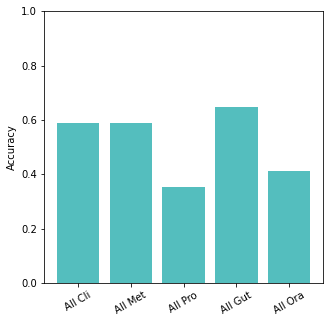

In [ ]:
#cerate and saves accuracy plot
barplot_data = [accuracy_clinical, accuracy_metabolomics, accuracy_proteomics, accuracy_gut, accuracy_oral]
names = ['All Cli', 'All Met', 'All Pro', 'All Gut', 'All Ora']
plt.figure(figsize=(5, 5))
plt.ylim(top=1)
plt.xticks(rotation = 30)
plt.ylabel('Accuracy')
plt.bar(names, barplot_data, color="#54bebe")
plt.savefig('../graphs/allRF.png')
plt.show()


##Random Forest on combinations

In [ ]:
#renames gut and oral markers to differanciate which cathegory they come from
#put all clinical, metabolomic and proteomic values into same dataframe
gut_biome.rename(columns=lambda x: x if '(GUT)' in x else x + ' (GUT)', inplace=True)
oral_biome.rename(columns=lambda x: x if '(ORAL)' in x else x + ' (ORAL)', inplace=True)
values = pd.concat([clinical_values.iloc[0:, 1:], metabolomic_values, proteomic_values, gut_biome, oral_biome], axis=1)

#a dictionary for all combos that are tested
  #key is the name of the combo and value is a list of the biomarkers
combos = {'6 Cli':['ALT (IU/L)', 'Insulin (mg/dL)', 'Uric acid (mg/dL)', 'GGT (U/L)', 'AST (IU/L)', 'Creatinine (mg/dL)'],
          '8 Met':['3-hydroxyisobutyrate', 'behenoyl dihydrosphingomyelin (d18:0/22:0)*', 'cys-gly, oxidized', 'gamma-glutamylisoleucine*', 'hexadecasphingosine (d16:1)*', 'imidazole lactate', 'N-acetylaspartate (NAA)', 'sphingomyelin (d18:1/20:0, d16:1/22:0)*'], 
          '5 Met+5 Cli':['N-methyltaurine', 'diacylglycerol (14:0/18:1, 16:0/16:1) [2]*', 'glucuronide of C14H22O4 (2)*', '1-palmitoleoylglycerol (16:1)*', 'phenol glucuronide', 'Total cholesterol (mg/dL)', 'High Density Lipoprotein (mg/dL)', 'ALT (IU/L)', 'AST (IU/L)', 'GGT (U/L)'], 
          '10 Cli':['ALT (IU/L)', 'Insulin (mg/dL)', 'Uric acid (mg/dL)', 'GGT (U/L)', 'AST (IU/L)', 'Triglycerides (mg/dL)', 'Glucose (mg/dL)', 'Potassium (mmol/L)', 'Sodium (mmol/L)', 'Total cholesterol (mg/dL)'], 
          '5 Met+3 Cli':['imidazole lactate', 'gamma-glutamylisoleucine*', 'sphingomyelin (d18:1/20:0, d16:1/22:0)*', 'phenol glucuronide', 'glucuronide of C14H22O4 (2)*', 'ALT (IU/L)', 'AST (IU/L)', 'GGT (U/L)'],
          '5 Pro+3 Cli':['CXCL9', 'CD244', 'LIF-R', 'CDCP1', 'FGF-21', 'ALT (IU/L)', 'AST (IU/L)', 'GGT (U/L)'],
          '3 Met+9 Cli':['ALT (IU/L)', 'Insulin (mg/dL)', 'Uric acid (mg/dL)', 'GGT (U/L)', 'AST (IU/L)', 'Glucose (mg/dL)', 'Weight (kg)', 'Triglycerides (mg/dL)', 'Body mass index (kg/m2)', 'phenol glucuronide', 'N,N-dimethyl-5-aminovalerate', '5-(galactosylhydroxy)-L-lysine'],
          '15 Met+3 Cli':['phenol glucuronide', 'N,N-dimethyl-5-aminovalerate', '5-(galactosylhydroxy)-L-lysine', 'N,N-dimethylalanine', 'N-methyltaurine', '3-(3-hydroxyphenyl)propionate sulfate', 'vanillic acid glycine', '3-hydroxy-2-methylpyridine sulfate', 'N-acetyl-1-methylhistidine*', 'diacylglycerol (14:0/18:1, 16:0/16:1) [2]*', '5alpha-pregnan-3beta,20alpha-diol disulfate', 'glucuronide of C14H22O4 (2)*', 'citrate', 'stearoyl sphingomyelin (d18:1/18:0)', '1-palmitoleoylglycerol (16:1)*', 'ALT (IU/L)', 'GGT (U/L)', 'AST (IU/L)'],
          '5 Met+8 Cli':['N-methyltaurine', 'diacylglycerol (14:0/18:1, 16:0/16:1) [2]*', 'glucuronide of C14H22O4 (2)*', '1-palmitoleoylglycerol (16:1)*', 'phenol glucuronide', 'Total cholesterol (mg/dL)', 'High Density Lipoprotein (mg/dL)', 'ALT (IU/L)', 'AST (IU/L)', 'GGT (U/L)', 'Glucose (mg/dL)', 'Triglycerides (mg/dL)', 'Waist circumference (cm)'],
          '3M + 3P + 3C':['CDCP1', 'FGF-21', 'ALT (IU/L)', 'AST (IU/L)', 'GGT (U/L)', 'CD244', 'phenol glucuronide', 'glucuronide of C14H22O4 (2)*', 'N-methyltaurine'],
          '2G + 2P + 4C':['ALT (IU/L)', 'AST (IU/L)', 'GGT (U/L)',  'CDCP1', 'Dorea_longicatena (GUT)', 'Uric acid (mg/dL)', 'LIF-R', 'Ruminococcus_bromii (GUT)'],
          'Lipids':['1-palmitoyl-2-oleoyl-GPC (16:0/18:1)', '1-palmitoyl-2-oleoyl-GPI (16:0/18:1)*', '1-stearoyl-2-oleoyl-GPC (18:0/18:1)', '1-stearoyl-2-oleoyl-GPI (18:0/18:1)*', '17alpha-hydroxypregnenolone 3-sulfate', '2-hydroxybehenate', '5alpha-androstan-3alpha,17beta-diol monosulfate (1)', '5alpha-pregnan-3beta,20alpha-diol disulfate', '5alpha-pregnan-3beta,20alpha-diol monosulfate (2)', '5alpha-pregnan-diol disulfate', 'behenoyl dihydrosphingomyelin (d18:0/22:0)*', 'bilirubin degradation product, C16H18N2O5 (1)', 'ceramide (d18:1/17:0, d17:1/18:0)*', 'ceramide (d18:1/20:0, d16:1/22:0, d20:1/18:0)*', 'cerotoylcarnitine (C26)*', 'dihomo-linolenoyl-choline', 'glycosyl ceramide (d18:1/20:0, d16:1/22:0)*', 'hexadecasphingosine (d16:1)*', 'N-palmitoyl-sphinganine (d18:0/16:0)', 'N-palmitoyl-sphingosine (d18:1/16:0)', 'N-stearoyl-sphingadienine (d18:2/18:0)*', 'N-stearoyl-sphinganine (d18:0/18:0)*', 'N-stearoyl-sphingosine (d18:1/18:0)*', 'palmitoyl-linoleoyl-glycerol (16:0/18:2) [2]*', 'palmitoyl-oleoyl-glycerol (16:0/18:1) [1]*', 'palmitoyl-oleoyl-glycerol (16:0/18:1) [2]*', 'pregnanediol-3-glucuronide', 'sphingomyelin (d18:0/18:0, d19:0/17:0)*', 'sphingomyelin (d18:0/20:0, d16:0/22:0)*', 'sphingomyelin (d18:1/18:1, d18:2/18:0)', 'sphingomyelin (d18:1/19:0, d19:1/18:0)*', 'sphingomyelin (d18:1/20:0, d16:1/22:0)*', 'sphingomyelin (d18:1/21:0, d17:1/22:0, d16:1/23:0)*', 'stearoylcarnitine (C18)'],
          '5 Lip':['17alpha-hydroxypregnenolone 3-sulfate', 'bilirubin degradation product, C16H18N2O5 (1)', '5alpha-pregnan-3beta,20alpha-diol disulfate', '5alpha-pregnan-diol disulfate', 'dihomo-linolenoyl-choline'],
          '10 Lip':['17alpha-hydroxypregnenolone 3-sulfate', 'bilirubin degradation product, C16H18N2O5 (1)', '5alpha-pregnan-3beta,20alpha-diol disulfate', '5alpha-pregnan-diol disulfate', 'dihomo-linolenoyl-choline', 'sphingomyelin (d18:1/18:1, d18:2/18:0)', '5alpha-androstan-3alpha,17beta-diol monosulfate (1)', '1-palmitoyl-2-oleoyl-GPC (16:0/18:1)', 'palmitoyl-linoleoyl-glycerol (16:0/18:2) [2]*', '5alpha-pregnan-3beta,20alpha-diol monosulfate (2)'],
          '15 Lip':['17alpha-hydroxypregnenolone 3-sulfate', 'bilirubin degradation product, C16H18N2O5 (1)', '5alpha-pregnan-3beta,20alpha-diol disulfate', '5alpha-pregnan-diol disulfate', 'dihomo-linolenoyl-choline', 'sphingomyelin (d18:1/18:1, d18:2/18:0)', '5alpha-androstan-3alpha,17beta-diol monosulfate (1)', '1-palmitoyl-2-oleoyl-GPC (16:0/18:1)', 'palmitoyl-linoleoyl-glycerol (16:0/18:2) [2]*', '5alpha-pregnan-3beta,20alpha-diol monosulfate (2)', 'N-stearoyl-sphinganine (d18:0/18:0)*', 'sphingomyelin (d18:1/20:0, d16:1/22:0)*', 'cerotoylcarnitine (C26)*', 'sphingomyelin (d18:0/20:0, d16:0/22:0)*', 'sphingomyelin (d18:0/18:0, d19:0/17:0)*'],
          '5 Lip+5 Cli':['17alpha-hydroxypregnenolone 3-sulfate', 'bilirubin degradation product, C16H18N2O5 (1)', '5alpha-pregnan-3beta,20alpha-diol disulfate', '5alpha-pregnan-diol disulfate', 'dihomo-linolenoyl-choline','ALT (IU/L)', 'Insulin (mg/dL)', 'Uric acid (mg/dL)', 'GGT (U/L)', 'AST (IU/L)'],
          '8 M + 6P + 5 C':['ALT (IU/L)', 'Uric acid (mg/dL)', 'GGT (U/L)', 'AST (IU/L)', 'Creatine Kinase (U/L)', 'sphingomyelin (d18:1/20:0, d16:1/22:0)*', 'hexadecasphingosine (d16:1)*', 'behenoyl dihydrosphingomyelin (d18:0/22:0)*', '3-hydroxyisobutyrate', 'imidazole lactate', 'gamma-glutamylisoleucine*', 'N-acetylaspartate (NAA)', 'cys-gly, oxidized', 'VEGFA', 'CDCP1', 'CD244', 'CD5', 'IL-12B', 'TNFRSF9'],
          '4 M + 5 P + 4 C':['CDCP1', 'ALT (IU/L)', 'IL-12B', 'GGT (U/L)', 'CD244', 'Uric acid (mg/dL)', 'VEGFA', 'AST (IU/L)', 'imidazole lactate', 'hexadecasphingosine (d16:1)*', 'TNFRSF9', 'cys-gly, oxidized', 'N-acetylaspartate (NAA)'],
          'Top 5 Cli':['ALT (IU/L)', 'Insulin (mg/dL)', 'Uric acid (mg/dL)', 'GGT (U/L)', 'AST (IU/L)'],
          'Top 5 Met':['phenol glucuronide', 'N,N-dimethyl-5-aminovalerate', '5-(galactosylhydroxy)-L-lysine', 'N,N-dimethylalanine', 'N-methyltaurine'],
          'Top 10 Met':['phenol glucuronide', 'N,N-dimethyl-5-aminovalerate', '5-(galactosylhydroxy)-L-lysine', 'N,N-dimethylalanine', 'N-methyltaurine', '3-(3-hydroxyphenyl)propionate sulfate', 'vanillic acid glycine', '3-hydroxy-2-methylpyridine sulfate', 'N-acetyl-1-methylhistidine*', 'diacylglycerol (14:0/18:1, 16:0/16:1) [2]*'],
          'Top 15 Met':['phenol glucuronide', 'N,N-dimethyl-5-aminovalerate', '5-(galactosylhydroxy)-L-lysine', 'N,N-dimethylalanine', 'N-methyltaurine', '3-(3-hydroxyphenyl)propionate sulfate', 'vanillic acid glycine', '3-hydroxy-2-methylpyridine sulfate', 'N-acetyl-1-methylhistidine*', 'diacylglycerol (14:0/18:1, 16:0/16:1) [2]*', '5alpha-pregnan-3beta,20alpha-diol disulfate', 'glucuronide of C14H22O4 (2)*', 'citrate', 'stearoyl sphingomyelin (d18:1/18:0)', '1-palmitoleoylglycerol (16:1)*'],
          'Top 5 Pro':['CXCL9', 'CD244', 'LIF-R', 'CDCP1', 'FGF-21'],
          'Top 5 Gut':['Dorea_longicatena (GUT)', 'Roseburia_intestinalis (GUT)', 'Barnesiella_intestinihominis (GUT)', 'Rothia_mucilaginosa (GUT)', 'Prevotella_sp_CAG_279 (GUT)'], 
          'Top 10 Gut':['Dorea_longicatena (GUT)', 'Roseburia_intestinalis (GUT)', 'Barnesiella_intestinihominis (GUT)', 'Rothia_mucilaginosa (GUT)', 'Prevotella_sp_CAG_279 (GUT)', 'Flavonifractor_plautii (GUT)', 'Coprococcus_comes (GUT)', 'Allisonella_histaminiformans (GUT)', 'Butyricimonas_virosa (GUT)', 'Ruminococcus_bromii (GUT)'],
          'Top 5 Ora':['Actinomyces_naeslundii (ORAL)', 'Campylobacter_concisus (ORAL)', 'Veillonella_infantium (ORAL)', 'Kingella_oralis (ORAL)', 'Porphyromonas_somerae (ORAL)'],
          'Top 10 Ora':['Actinomyces_naeslundii (ORAL)', 'Campylobacter_concisus (ORAL)', 'Veillonella_infantium (ORAL)', 'Kingella_oralis (ORAL)', 'Porphyromonas_somerae (ORAL)', 'Abiotrophia_sp_HMSC24B09 (ORAL)', 'Prevotella_nigrescens (ORAL)', 'Solobacterium_moorei (ORAL)', 'Bacteroides_uniformis (ORAL)', 'Neisseria_flavescens (ORAL)'],
          }

In [ ]:
#runs all combos through random forest
accuracies = []
names = []
for name, columns in combos.items():
  print(name)
  RF_combo, accuracy, oob = RF_Execute(values[columns], metadata, name=name)
  names.append(name)
  accuracies.append(accuracy)
  save_RF(RF_combo, accuracy, oob, name)

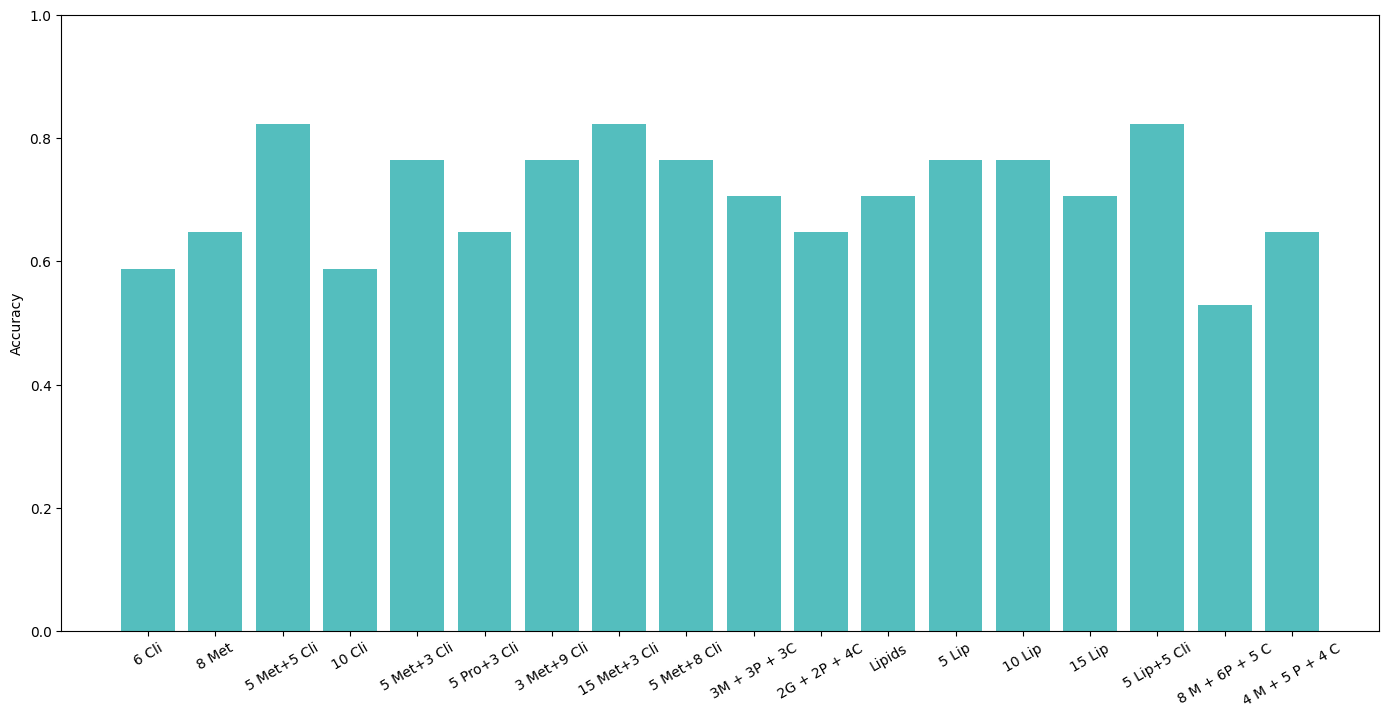

In [ ]:
#makes and saves a barplot of accuracies
plt.figure(figsize=(17,8))
plt.ylim(top=1)
plt.xticks(rotation = 30)
plt.ylabel('Accuracy')
plt.bar(names, accuracies, width=0.8, color="#54bebe")
plt.savefig('../graphs/combos.png', bbox_inches='tight')
plt.show()

In [ ]:
#runs all combos through random forest with revisits as test data
accuracies = []
names = []
for name, columns in combos.items():
  #if the marker doesn't exist in the combination it will be left out of the revisit forest
  left = [column for column in columns if not column in redata.columns]
  columns = [column for column in columns if column in redata.columns]
  print(name+' rev')
  RF_combo, accuracy, oob = RF_Execute(values[columns], metadata, tester_data=redata[columns], tester_meta=metadata2, name=name+' rev')
  print(f'{left} were left out')
  save_RF(RF_combo, accuracy, oob, name+'_rev')
  names.append(name+' rev')
  accuracies.append(accuracy)


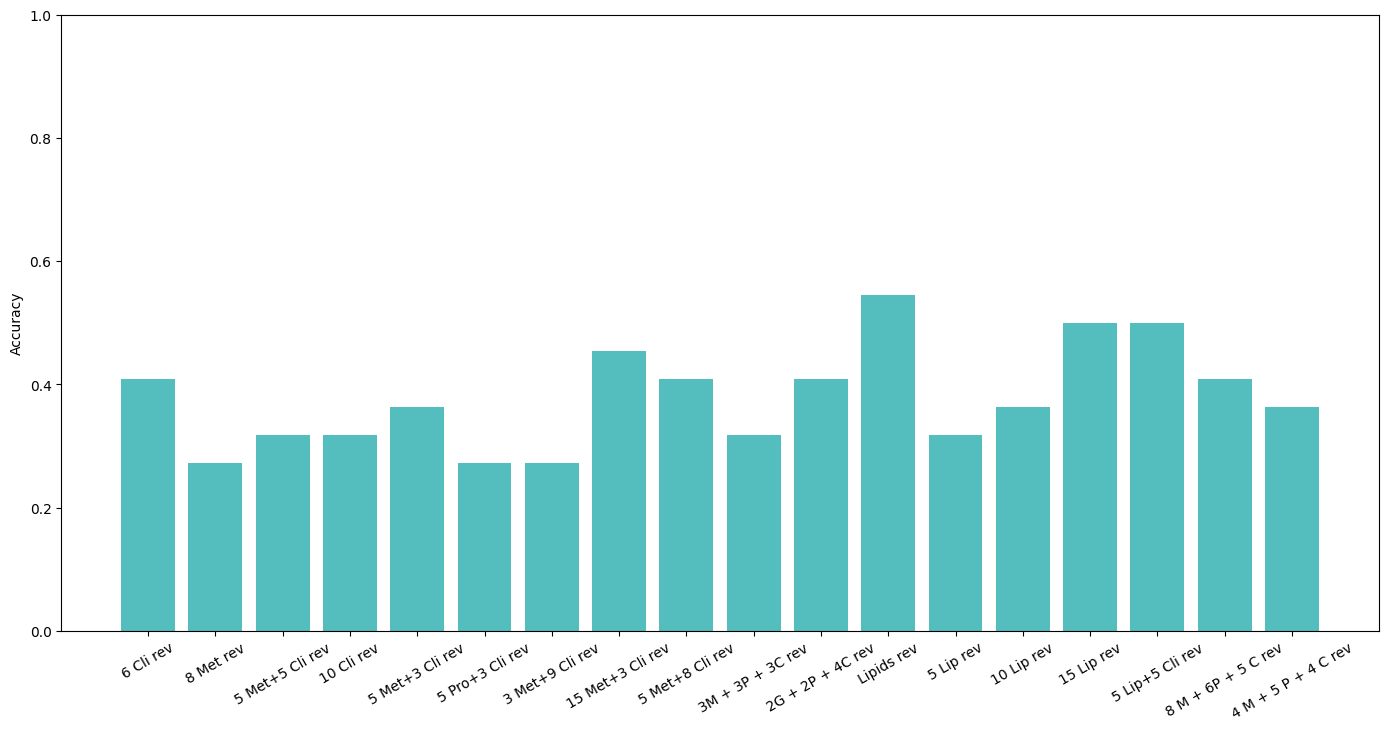

In [ ]:
#creates and saves plot of accuracies
plt.figure(figsize=(17,8))
plt.ylim(top=1)
plt.xticks(rotation = 30)
plt.ylabel('Accuracy')
plt.bar(names, accuracies, width=0.8, color="#54bebe")
plt.savefig('../graphs/combosrev.png', bbox_inches='tight')
plt.show()